In [2]:
import pandas as pd
from textblob import TextBlob
from pathlib import Path
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# Read in the data frame

In [2]:
#read in file
file_path = Path("../data/cleaned_data/cleaned_training_tweets.csv")

df = pd.read_csv(file_path, encoding='ISO-8859-1')
df.head()

,target,cleaned_text
0,0,upset update facebook texting might cry result...
1,0,dived many time managed save rest go bound
2,0,whole body feel itchy like fire
3,0,behaving see
4,0,whole crew


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 2 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   target        1599999 non-null  int64 
 1   cleaned_text  1563712 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [27]:
# Pre-proccess data.
import nltk
# Pre-Processing the text
def cleaning(text):
    text = text.lower()
    text = ' '.join([word for word in text.split() if word.isalpha()])
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]
    return ' '.join(lemmatized_text)

df['cleaned_text'] = df['text'].apply(cleaning)


In [22]:
df['cleaned_text'] = df['cleaned_text'].astype(str)

In [29]:
df = df.drop(columns=['text'])

In [30]:
cleaned_file_path = '../data/cleaned_data/cleaned_training_tweets.csv'
df.to_csv(cleaned_file_path, index=False)

## Copy the DataFrame to test both TextBlob and VaderSentiment

In [4]:
original_df = df.copy()

In [5]:
text_blob_df = df.copy()

In [6]:
#drop the target column
text_blob_df = text_blob_df.drop(columns=['target'])
text_blob_df.head()

,cleaned_text
0,upset update facebook texting might cry result...
1,dived many time managed save rest go bound
2,whole body feel itchy like fire
3,behaving see
4,whole crew


In [24]:
vader_sentiment_df = df.copy()

In [ ]:
#drop the target column
vader_sentiment_df = vader_sentiment_df.drop(columns=['target'])
vader_sentiment_df.head()

## Run original data set through Bag of Words Vectorization Based Model

In [38]:
#Pre-Prcoessing and Bag of Word Vectorization using Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

cv = CountVectorizer(stop_words='english', ngram_range=(1, 1))
text_counts = cv.fit_transform(original_df['cleaned_text'])

In [39]:
#Splitting the data into trainig and testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, original_df['target'], test_size=0.25, random_state=5)

In [40]:
#Training the model
from sklearn.naive_bayes import MultinomialNB

MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

MultinomialNB()

In [42]:
from sklearn import metrics

predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, Y_test)
print("Accuracy Score: ", accuracy_score)

Accuracy Score:  0.7342025


In [43]:
# Calculate precision, recall, and F1-score
precision = metrics.precision_score(Y_test, predicted, average='weighted')
recall = metrics.recall_score(Y_test, predicted, average='weighted')
f1_score = metrics.f1_score(Y_test, predicted, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.7345913371141636
Recall: 0.7342025
F1 Score: 0.7340973573064117


## TextBlob Sentiment analysis

In [11]:
# Define a function to perform sentiment analysis using TextBlob and convert to labels
def analyze_sentiment_blob(text):
    if isinstance(text, float):
        return 'neutral'
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity



# Apply the function to the 'text' column and create a new column 'sentiment_label'
text_blob_df['textblob_sentiment'] = text_blob_df['cleaned_text'].apply(analyze_sentiment_blob)
text_blob_df.head()

,cleaned_text,textblob_sentiment
0,upset update facebook texting might cry result...,0.0
1,dived many time managed save rest go bound,0.5
2,whole body feel itchy like fire,0.2
3,behaving see,0.0
4,whole crew,0.2


In [13]:
# Define a function to perform sentiment analysis using TextBlob and convert to labels
def analyze_sentiment_blob(text):
    if isinstance(text, float):
        return 'neutral'
    analysis = TextBlob(str(text))
    polarity = analysis.sentiment.polarity
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to the 'cleaned_text' column and create a new column 'textblob_sentiment'
text_blob_df['textblob_sentiment_lables'] = text_blob_df['cleaned_text'].apply(analyze_sentiment_blob)

text_blob_df.head()

,cleaned_text,textblob_sentiment,textblob_sentiment_lables
0,upset update facebook texting might cry result...,0.0,neutral
1,dived many time managed save rest go bound,0.5,positive
2,whole body feel itchy like fire,0.2,positive
3,behaving see,0.0,neutral
4,whole crew,0.2,positive


In [15]:
text_blob_df.value_counts('textblob_sentiment_lables')

textblob_sentiment_lables
neutral     825566
positive    546179
negative    228254
dtype: int64

In [17]:
# specify where to place cleaned data and what to call it
cleaned_file_path = '../data/cleaned_data/text_blob_sentiment.csv'

#save data using the cleaned file path.
text_blob_df.to_csv(cleaned_file_path, index=False)

In [39]:
textblob_df = pd.read_csv('../data/cleaned_data/text_blob_sentiment.csv')

### Now run textBlob through the Bag of Words vectorization model

In [46]:
#fill any missing values with an empty str
textblob_df['cleaned_text'] = textblob_df['cleaned_text'].fillna('')

In [47]:
#Pre-Process the data using bag of words Vectorization-Based Model
cv = CountVectorizer(stop_words='english', ngram_range=(1, 1))
text_counts = cv.fit_transform(textblob_df['cleaned_text'])

In [49]:
#Splitting the data into trainig and testing
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, textblob_df['textblob_sentiment_lables'], test_size=0.25, random_state=5)

In [50]:
#train the model
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

MultinomialNB()

In [51]:
#make predictions
predicted = MNB.predict(X_test)


In [53]:
# Calculate accuracy
from sklearn import metrics
accuracy_score = metrics.accuracy_score(predicted, Y_test)
print("Accuracy Score: ", accuracy_score)

Accuracy Score:  0.856185


In [54]:
# Calculate precision, recall, and F1-score
precision = metrics.precision_score(Y_test, predicted, average='weighted')
recall = metrics.recall_score(Y_test, predicted, average='weighted')
f1_score = metrics.f1_score(Y_test, predicted, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.8598559899324191
Recall: 0.856185
F1 Score: 0.8533827640080314


## VaderSentiment analysis

In [25]:
sentiment = SentimentIntensityAnalyzer()
#create a function to apply to our data frame
def analyze_sentiment_vader (text):    
    sentiment_score = sentiment.polarity_scores(text)
    return sentiment_score['compound']
#apply the created function to the copied vader_sentiment_df data frame    
vader_sentiment_df['sentiment_vader'] = vader_sentiment_df['cleaned_text'].apply(analyze_sentiment_vader)
vader_sentiment_df.head()

,target,cleaned_text,sentiment_vader
0,0,upset update facebook texting might cry result...,-0.6908
1,0,dived many time managed save rest go bound,0.4939
2,0,whole body feel itchy like fire,-0.2500
3,0,behaving see,0.0000
4,0,whole crew,0.0000


In [ ]:
# Define a function to convert sentiment scores to labels
def sentiment_to_label(score):
    if score >= 0.1:
        return 'positive'
    elif score <= -0.1:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to the 'sentiment_vader' column and create a new column 'sentiment_label'
vader_sentiment_df['vader_sentiment_label'] = vader_sentiment_df['sentiment_vader'].apply(sentiment_to_label)

# Display the DataFrame with sentiment labels
vader_sentiment_df.head()

In [34]:
vader_sentiment_df.head()

,target,cleaned_text,sentiment_vader,vader_sentiment_label
0,0,upset update facebook texting might cry result...,-0.6908,negative
1,0,dived many time managed save rest go bound,0.4939,positive
2,0,whole body feel itchy like fire,-0.2500,negative
3,0,behaving see,0.0000,neutral
4,0,whole crew,0.0000,neutral


In [30]:
vader_sentiment_df.value_counts('sentiment_label')

sentiment_label
positive    670741
neutral     621348
negative    307910
dtype: int64

In [ ]:
# specify where to place cleaned data and what to call it
cleaned_file_path = '../data/cleaned_data/vader_sentiment.csv'

#save data using the cleaned file path.
vader_sentiment_df.to_csv(cleaned_file_path, index=False)

In [57]:
vader_df = pd.read_csv('../data/cleaned_data/vader_sentiment.csv')

### Now run Vader through the Bag of Words vectorization model

In [61]:
#fill any missing values with an empty str
vader_df['cleaned_text'] = vader_df['cleaned_text'].fillna('')

In [62]:
#Pre-Process the data using bag of words Vectorization-Based Model
cv = CountVectorizer(stop_words='english', ngram_range=(1, 1))
text_counts = cv.fit_transform(vader_df['cleaned_text'])

In [64]:
#Splitting the data into trainig and testing
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, vader_df['vader_sentiment_label'], test_size=0.25, random_state=5)

In [65]:
#train the model
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

MultinomialNB()

In [66]:
#make predictions
predicted = MNB.predict(X_test)

In [67]:
# Calculate accuracy
accuracy_score = metrics.accuracy_score(predicted, Y_test)
print("Accuracy Score: ", accuracy_score)

Accuracy Score:  0.8470225


In [68]:
# Calculate precision, recall, and F1-score
precision = metrics.precision_score(Y_test, predicted, average='weighted')
recall = metrics.recall_score(Y_test, predicted, average='weighted')
f1_score = metrics.f1_score(Y_test, predicted, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.8507783927062014
Recall: 0.8470225
F1 Score: 0.8459390728898293


## Compare the 3 csv files. Bert, Vader, and Textblob

In [3]:
#read in the files
vader_df = pd.read_csv("../data/cleaned_data/vader_sentiment.csv")
bert_df = pd.read_csv("../data/cleaned_data/bert_sentiment_analysis_50000.csv")
textblob_df = pd.read_csv("../data/cleaned_data/text_blob_sentiment.csv")

In [4]:
vader_df = vader_df.head(15000)
textblob_df = textblob_df.head(15000)
bert_df = bert_df.head(15000)

In [5]:
merged_df = pd.merge(vader_df, textblob_df, on='cleaned_text', how='inner')
merged_df.head()

,cleaned_text,sentiment_vader,vader_sentiment_label,textblob_sentiment,textblob_sentiment_lables
0,upset update facebook texting might cry result...,-0.6908,negative,0.0,neutral
1,dived many time managed save rest go bound,0.4939,positive,0.5,positive
2,whole body feel itchy like fire,-0.2500,negative,0.2,positive
3,behaving see,0.0000,neutral,0.0,neutral
4,whole crew,0.0000,neutral,0.2,positive


In [6]:
merged_df = pd.merge(merged_df, bert_df, on='cleaned_text', how='inner')
merged_df.head()

,cleaned_text,sentiment_vader,vader_sentiment_label,textblob_sentiment,textblob_sentiment_lables,sentiment_scores,sentiment_labels
0,upset update facebook texting might cry result...,-0.6908,negative,0.0,neutral,0.799103,negative
1,dived many time managed save rest go bound,0.4939,positive,0.5,positive,0.714438,neutral
2,whole body feel itchy like fire,-0.2500,negative,0.2,positive,0.569125,negative
3,behaving see,0.0000,neutral,0.0,neutral,0.753781,neutral
4,whole crew,0.0000,neutral,0.2,positive,0.727418,neutral


In [7]:
import numpy as np
# Create a new column 'matching_label' with default value 0
merged_df['matching_label'] = 0

# Conditions to check for matching labels
condition1 = (merged_df['vader_sentiment_label'] == merged_df['textblob_sentiment_lables']) & (merged_df['vader_sentiment_label'] == merged_df['sentiment_labels'])
condition2 = (merged_df['vader_sentiment_label'] == merged_df['textblob_sentiment_lables']) & (merged_df['vader_sentiment_label'] != merged_df['sentiment_labels'])
condition3 = (merged_df['vader_sentiment_label'] != merged_df['textblob_sentiment_lables']) & (merged_df['vader_sentiment_label'] == merged_df['sentiment_labels'])
condition4 = (merged_df['vader_sentiment_label'] != merged_df['textblob_sentiment_lables']) & (merged_df['textblob_sentiment_lables'] == merged_df['sentiment_labels'])

# Set values based on conditions
merged_df['matching_label'] = np.where(condition1, 'All 3 Match',
                           np.where(condition2, 'Vader, Textblob Match',
                           np.where(condition3, 'Vader, Bert Match',
                           np.where(condition4, 'Textblob, Bert Match', 'None Match'))))

merged_df.head()


,cleaned_text,sentiment_vader,vader_sentiment_label,textblob_sentiment,textblob_sentiment_lables,sentiment_scores,sentiment_labels,matching_label
0,upset update facebook texting might cry result...,-0.6908,negative,0.0,neutral,0.799103,negative,"Vader, Bert Match"
1,dived many time managed save rest go bound,0.4939,positive,0.5,positive,0.714438,neutral,"Vader, Textblob Match"
2,whole body feel itchy like fire,-0.2500,negative,0.2,positive,0.569125,negative,"Vader, Bert Match"
3,behaving see,0.0000,neutral,0.0,neutral,0.753781,neutral,All 3 Match
4,whole crew,0.0000,neutral,0.2,positive,0.727418,neutral,"Vader, Bert Match"


In [8]:
merged_df.value_counts('matching_label')

matching_label
All 3 Match              16809859
Textblob, Bert Match        23857
Vader, Bert Match            5836
Vader, Textblob Match        3707
None Match                    727
dtype: int64

In [13]:
# Filter out rows where all three labels match
filtered_df = merged_df[merged_df['matching_label'] != "All 3 Match"]

# Count the occurrences of each matching_label category after filtering
label_counts = filtered_df['matching_label'].value_counts()
label_counts

Textblob, Bert Match     23857
Vader, Bert Match         5836
Vader, Textblob Match     3707
None Match                 727
Name: matching_label, dtype: int64

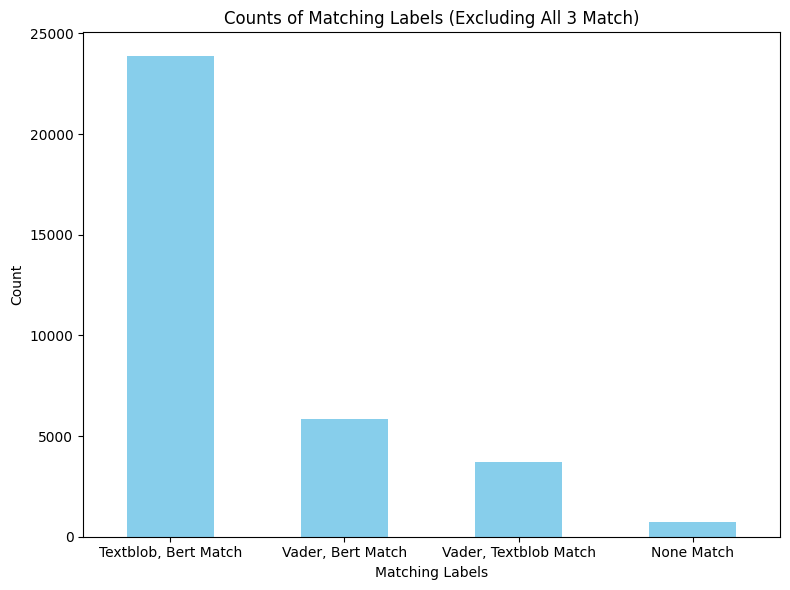

In [14]:
import matplotlib.pyplot as plt
# Create a bar plot
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Matching Labels')
plt.ylabel('Count')
plt.title('Counts of Matching Labels (Excluding All 3 Match)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()